# Field Goals: An Observational Study ⛰️

* Hypothesis: Long range field goals have a greater change of conversion at altitude than sea-level.
* Hypothesis: Icing a kicker prior to an attempty reduces the likelihood of conversion.

In [70]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import mysql.connector
import itertools
import dtale
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
from datetime import datetime as dt
from util.fg_data import clean, get_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing

In [71]:
# load and clean the data
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df = df.drop(['fkicker', 'home_team', 'stadium', 'team', 'XP', 'humid', 'kicks', 'age', 'form'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18803 entries, 2166 to 871048
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   good           18803 non-null  int64
 1   dist           18803 non-null  int64
 2   year           18803 non-null  int64
 3   seasons        18803 non-null  int64
 4   temperature    18803 non-null  int32
 5   altitude       18803 non-null  int64
 6   wind           18803 non-null  int32
 7   away_game      18803 non-null  int64
 8   postseason     18803 non-null  int64
 9   iced           18803 non-null  int64
 10  turf           18803 non-null  int64
 11  precipitation  18803 non-null  int64
 12  pressure       18803 non-null  int64
dtypes: int32(2), int64(11)
memory usage: 1.9 MB


In [72]:
# df = pd.read_csv('../data/field_goals.csv', index_col=0)
# df.drop(['kicks','age','form'], axis=1, inplace=True)
# df.info()

## Variable of Interest

We filter for away kicks at altitude because only Denver home games are at altitude, so need to avoid biasing for Broncos kicker?

In [73]:
on = 'iced'
# drop = ['turf']
# df = df[(df['away_game']==1) | (df['altitude']==0)] # for altitude study
df[on] = df[on].astype(bool)

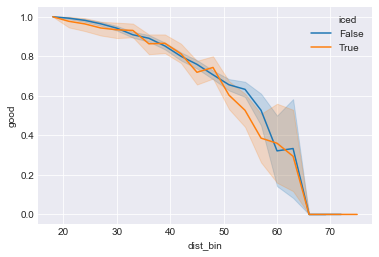

In [74]:
df_ = df.copy()
df_['dist_bin'] = 3*round(df_['dist']/3)
sns.lineplot(x='dist_bin', y='good', hue=on, data=df_)

In [75]:
print(df[on].value_counts())

False    16452
True      2351
Name: iced, dtype: int64


## Matching

### Coarsened Exact Matching

In [76]:
from util.matching import CEM

L1, which is a metric of the joint-distribution of covariates, should be monotonically decreasing with progressively finer coarsenings (i.e. less and less observations matched).

In [77]:
bins = {
    'dist': range(3,5),
    'year': range(3,5),
    'seasons': range(3,5),
    'temperature': range(2,5),
    'wind': range(3,4),
    'pressure': range(3,8),
    'postseason': [2],
    'iced': [2],
    'precipitation': [2],
    'altitude': [2],
    'good': [2],
    'turf': [2],
    'away_game': [2],
    'altitude': [2],
}

L1_results = CEM(df, treatment=on, outcome='good').relax(bins)
# plot % treatment matched with increasing L1
L1_results

100%|██████████| 120/120 [20:23<00:00, 10.20s/it]


,statistic,controls,treatments,coarsening
0,0.399622,14547,2120,"{'dist': 3, 'year': 3, 'seasons': 3, 'temperat..."
1,0.397466,13911,2113,"{'dist': 3, 'year': 3, 'seasons': 3, 'temperat..."
2,0.397086,13867,2088,"{'dist': 3, 'year': 3, 'seasons': 3, 'temperat..."
3,0.397744,13831,2041,"{'dist': 3, 'year': 3, 'seasons': 3, 'temperat..."
4,0.396887,13586,2028,"{'dist': 3, 'year': 3, 'seasons': 3, 'temperat..."
...,...,...,...,...
115,0.383152,12537,1969,"{'dist': 4, 'year': 4, 'seasons': 4, 'temperat..."
116,0.375065,11464,1943,"{'dist': 4, 'year': 4, 'seasons': 4, 'temperat..."
117,0.374428,11425,1914,"{'dist': 4, 'year': 4, 'seasons': 4, 'temperat..."
118,0.375341,11370,1818,"{'dist': 4, 'year': 4, 'seasons': 4, 'temperat..."


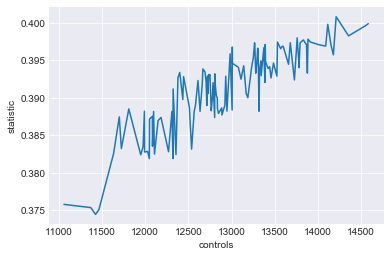

In [78]:
sns.lineplot(x='treatments', y='statistic', data=L1_results)

Distance is the most important covariate, so we will perform CEM for different level of distance coarsening and regress on the weighted results. We plot the evolution of the regression coefficients for each binning on distance.

In [79]:
bins = {
    'dist': range(2,11),
    'year': 4,
    'seasons': 3,
    'temperature': 3,
    'wind': 3,
    'pressure': 7,
    'postseason': 2,
    'iced': 2,
    'precipitation': 2,
    'altitude': 2,
    'good': 2,
    'turf': 2,
    'away_game': 2,
    'altitude': 2,
}

In [80]:
#model
cem = CEM(df, treatment=on, outcome='good')
summary = cem.regress(bins=bins, drop=drop)

100%|██████████| 9/9 [01:25<00:00,  9.46s/it]


In [84]:
from util.matching import summary_to_frame
results = pd.concat([summary_to_frame(s['summary'],s['n_bins'],s['vc'], dtype=float) for s in summary.values()]).dropna()
# results = results.loc[results['P>|z|']<=0.1, :]
results

,covariate,coef,std err,z,P>|z|,[0.025,0.975],observations,n_bins,controls,treatments
1,Intercept,-78.2638,8.753,-8.941,0.000,-95.420,-61.108,15446.0,2.0,13469.0,1977.0
2,iced[T.True],-0.1431,0.068,-2.097,0.036,-0.277,-0.009,15446.0,2.0,13469.0,1977.0
3,dist,-0.1144,0.003,-38.516,0.000,-0.120,-0.109,15446.0,2.0,13469.0,1977.0
4,year,0.0421,0.004,9.646,0.000,0.034,0.051,15446.0,2.0,13469.0,1977.0
5,seasons,0.0041,0.005,0.827,0.408,-0.006,0.014,15446.0,2.0,13469.0,1977.0
...,...,...,...,...,...,...,...,...,...,...,...
8,wind,-0.0282,0.005,-5.731,0.000,-0.038,-0.019,11652.0,10.0,10007.0,1645.0
9,away_game,-0.0517,0.053,-0.973,0.331,-0.156,0.052,11652.0,10.0,10007.0,1645.0
10,postseason,0.5123,0.197,2.606,0.009,0.127,0.898,11652.0,10.0,10007.0,1645.0
11,precipitation,-0.3055,0.112,-2.729,0.006,-0.525,-0.086,11652.0,10.0,10007.0,1645.0


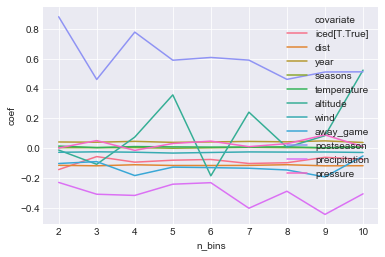

In [85]:
sns.lineplot(x='n_bins', y='coef', data=results.loc[results['covariate']!='Intercept', :], hue='covariate')

Let's assess the marginal distributions for the covariates on the finest coarsening of distance.

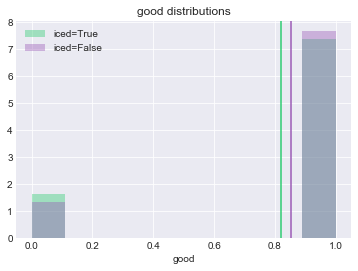

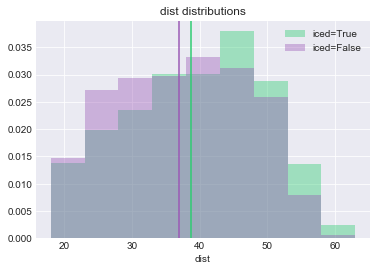

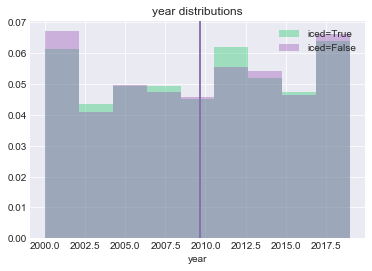

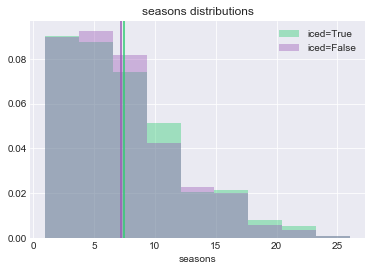

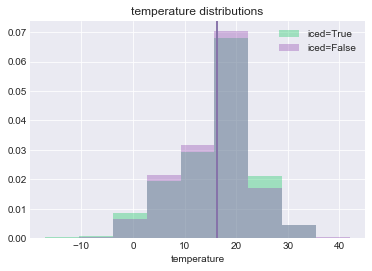

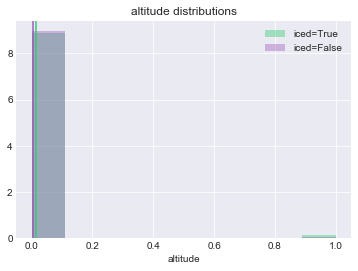

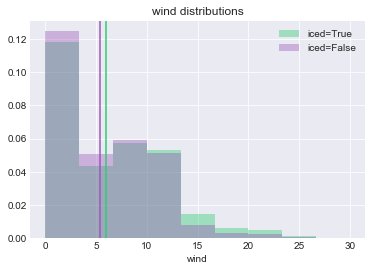

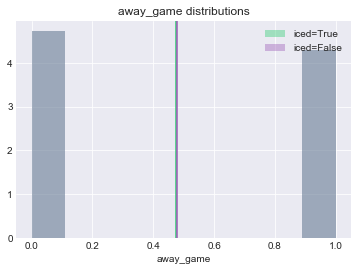

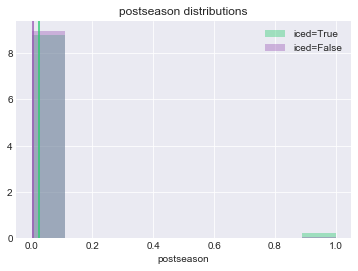

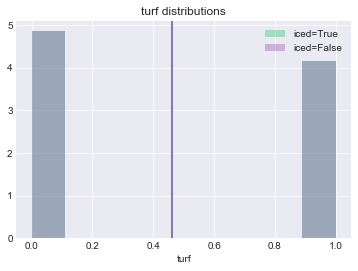

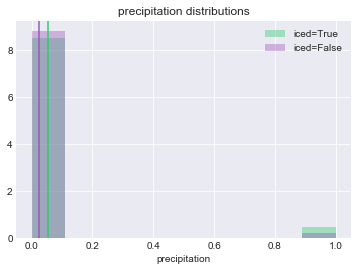

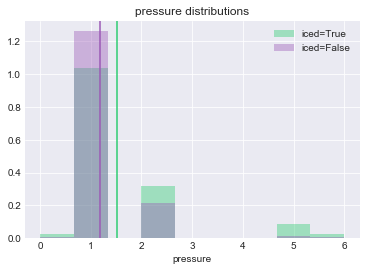

In [83]:
from util.matching import covariate_dists
covariate_dists(cem.data.loc[cem.weights>0, :], on=on, kde=False, hist=True, n_bins=10)

## Model

We work within a Bayesian framework, setting a prior distribution on the true population proportion and update the prior after our observations. The Beta-Binomial conjugacy makes this process relatively pain-free. Our prior mean is the sample population proportion (all kicks).

### NOTE: Stratify on distance!

In [151]:
# dist_level = (df_matched['dist']>=40) & (df_matched['dist']<50)
dist_level = (df_matched['dist']>=45)
print(len(df_matched.loc[(df_matched[on]==1) & dist_level, :]), on, len(df_matched.loc[(df_matched[on]==0) & dist_level, :]), f'not {on}.')

398 iced 1130 not iced.


In [152]:
from scipy.stats import beta
p_hat = df_matched.loc[dist_level, 'good'].mean()
alpha_ = 10
beta_ = int(round(alpha_*(1-p_hat)/p_hat))
print(f'alpha: {alpha_}, beta: {beta_}')

alpha: 10, beta: 4


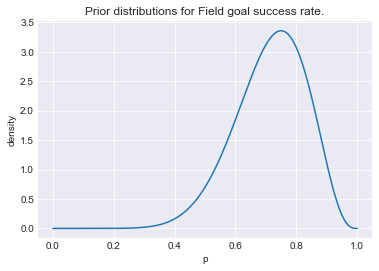

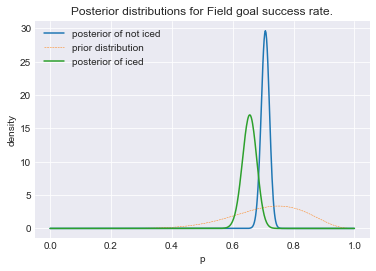

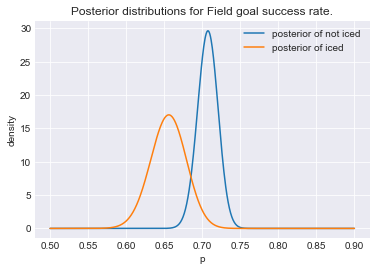

In [153]:
from util.bayes import BetaBinomial

control = BetaBinomial(alpha_, beta_, f'not {on}')
treatment = BetaBinomial(alpha_, beta_, on)
control.plot_prior(show=True)
plt.cla()

control.observe(df_matched.loc[(df_matched[on]==0) & dist_level, 'good'])
treatment.observe(df_matched.loc[(df_matched[on]==1) & dist_level, 'good'])

control.plot_posterior(prior=False)
treatment.plot_posterior(show=True, prior=True)

# zoom in
x = np.linspace(0.5,0.9,500)
control.plot_posterior(x, prior=False, show=False)
treatment.plot_posterior(x, prior=False, show=True)

samples = 20000
samples_posterior_c = control.sample(samples)
samples_posterior_t = treatment.sample(samples)

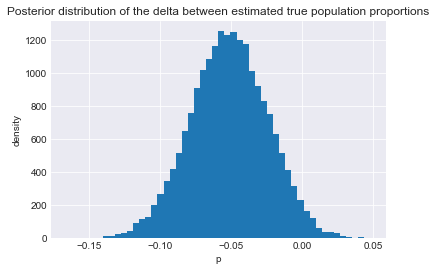

2% likely that iced has a greater true population proportion of converted field goals.
-0.05 is the median difference, with 50% credible interval of (0.0,-0.1).


In [154]:
posterior_diff = samples_posterior_t - samples_posterior_c

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions')
plt.show()
gt = int((samples_posterior_t>samples_posterior_c).mean()*100)
print(f'{gt}% likely that {on} has a greater true population proportion of converted field goals.')

from scipy.stats import bayes_mvs
alpha = 0.5
center, _, _ = bayes_mvs(posterior_diff, alpha=alpha)
print(f'{round(center.statistic,2)} is the median difference, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

We are sometimes interested in relative increase. For instance, the difference between 0.6 and 0.7 is relatively larger than the difference between 0.7 and 0.8.
We calculate relative increase of our treatment over control using our posterior distributions.

0 % likely relative lift is greater than 5%.
-0.07 is the median relative lift, with 50% credible interval of (0.0,-0.15).


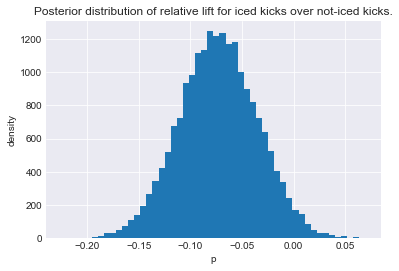

In [155]:
posterior_relative = (samples_posterior_t-samples_posterior_c)/samples_posterior_c
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title(f'Posterior distribution of relative lift for {on} kicks over not-{on} kicks.')
print(int((posterior_relative>0.05).mean()*100), r'% likely relative lift is greater than 5%.')

alpha = 0.5
center, _, _ = bayes_mvs(posterior_relative, alpha=alpha)
print(f'{round(center.statistic,2)} is the median relative lift, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')